## Sign Language Detection using Resnet 50

In [42]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [43]:
import sklearn
print(sklearn.__version__)

1.2.2


### Import Libraries 

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf
import sklearn as sklearn
import pandas as pd


from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop

from keras.models import Model
from keras.preprocessing import image
%matplotlib inline
import os
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, roc_curve
from sklearn.metrics import classification_report
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [63]:
from tensorflow.python.keras.layers import Input, Dense, Flatten, Lambda, Dropout

In [64]:
# import pathlib
# data_dir = "/content/sign_mnist_test.csv"
# data_dir = pathlib.Path(data_dir)
data_df = pd.read_csv('sign_mnist_train.csv')
test_df = pd.read_csv('sign_mnist_test.csv')

In [65]:
from keras.utils import to_categorical
import cv2
X = data_df.iloc[:, 1:].values.reshape(-1, 28, 28, 1)
X = [cv2.merge((img, img, img)) for img in X]
X = np.array(X)
y = data_df.iloc[:, 0].values
y = to_categorical(y,num_classes=26)

In [66]:
X_resized = []
for img in X:
    img = np.array(img).astype('uint8')
    img = PIL.Image.fromarray(img).resize((32, 32))
    X_resized.append(np.array(img))
X_resized = np.array(X_resized)

###  Image Data Augmentation

We have implemented Image Augmentation using ImageDataGenerator - an augmented image generator API in Keras. It generates batches of image data with real-time data augmentation. For practical applications we have applied rotation, height/weight shift, zoom, flip and brightness high/low to our training dataset.

In [67]:
# # ImageDataGenerator
# datagen = ImageDataGenerator(
#     validation_split=0.2,
#          rotation_range=10, # rotation
#          width_shift_range=0.2, # horizontal shift
#          height_shift_range=0.2, # vertical shift
#          zoom_range=0.2, # zoom
#          horizontal_flip=True, # horizontal flip
#          brightness_range=[0.2,1.2]) # brightness


# train_ds = datagen.flow_from_dataframe(train_df,
#                                            class_mode = 'categorical',
#                                            target_size = (180, 180),
#                                            batch_size=32,
#                                        subset='training',
#                                            seed=46)
# val_ds = test_datagen.flow_from_dataframe(train_df,
#                                      class_mode = 'categorical',
#                                      target_size = (180, 180),
#                                      batch_size=32,
#                                           subset='validation',
#                                      seed=46)
datagen = ImageDataGenerator(
    validation_split=0.2,
    rotation_range=10, # rotation
    width_shift_range=0.2, # horizontal shift
    height_shift_range=0.2, # vertical shift
    zoom_range=0.2, # zoom
    horizontal_flip=True, # horizontal flip
    brightness_range=[0.2,1.2] # brightness
)
test_datagen=ImageDataGenerator(validation_split=0.2)
# Split data into training and validation sets
# train_df = data_df.sample(frac=0.8, random_state=42)
# val_df = data_df.drop(train_df.index)

# # Define data generators for training and validation
# train_generator = datagen.flow_from_dataframe(
#     dataframe=train_df,
#     directory=None,
#     x_col='filename',
#     y_col='label',
#     target_size=(180, 180),
#     batch_size=32,
#     subset='training'
# )

# val_generator = datagen.flow_from_dataframe(
#     dataframe=val_df,
#     directory=None,
#     x_col='filename',
#     y_col='label',
#     target_size=(180, 180),
#     batch_size=32,
#     subset='validation'
# )
train_generator = datagen.flow(X_resized, y, batch_size=128, subset='training')
val_generator = test_datagen.flow(X_resized, y, batch_size=128, subset='validation')



Metrics have been removed from Keras core. We need to calculate them manually.

In [68]:
from tensorflow.keras import backend as K
def precision(y_true, y_pred):
    """ Precision metric. Only computes a batch-wise average of precision. Computes the precision, a metric for multi-label classification of
    how many selected items are relevant."""
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    """ Recall metric. Only computes a batch-wise average of recall. Computes the recall, a metric for multi-label classification of
    how many relevant items are selected. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1(y_true, y_pred):
    precision_f = precision(y_true, y_pred)
    recall_f = recall(y_true, y_pred)
    return 2*((precision_f*recall_f)/(precision_f+recall_f+K.epsilon()))

### Implement the Deep Learning Model - Resnet50

ResNet-50 is a convolutional neural network that is 50 layers deep. We can load a pretrained version of the network trained on more than a million images from the ImageNet database.

In [69]:
resnet_model = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,
                   input_shape=(32,32,3),
                   pooling='avg', classes=26,
                   weights='imagenet')
for layer in pretrained_model.layers:
        layer.trainable=False

resnet_model.add(pretrained_model)

In [70]:
# Fully Connected Layer
resnet_model.add(Flatten())
resnet_model.add(Dense(512, activation='relu'))
resnet_model.add(Dense(26, activation='softmax'))

In [71]:
resnet_model.summary()
print(X.shape)
print(y.shape)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 module_wrapper_12 (ModuleWr  (None, 2048)             0         
 apper)                                                          
                                                                 
 module_wrapper_13 (ModuleWr  (None, 512)              1049088   
 apper)                                                          
                                                                 
 module_wrapper_14 (ModuleWr  (None, 26)               13338     
 apper)                                                          
                                                                 
Total params: 24,650,138
Trainable params: 1,062,426
Non-trainable params: 23,587,712
__________________________________

In [73]:
resnet_model.compile(optimizer=RMSprop(lr=0.01),loss='categorical_crossentropy', metrics = ['accuracy',f1, precision,recall])

history = resnet_model.fit(train_generator, validation_data=val_generator, epochs=50)

Epoch 1/50
172/172 [==============================] - 30s 147ms/step - loss: 1.6546 - accuracy: 0.5173 - f1: 0.4917 - precision: 0.6651 - recall: 0.3938 - val_loss: 0.8974 - val_accuracy: 0.6986 - val_f1: 0.6845 - val_precision: 0.7995 - val_recall: 0.5993
Epoch 2/50
172/172 [==============================] - 20s 113ms/step - loss: 1.0380 - accuracy: 0.6584 - f1: 0.6459 - precision: 0.7646 - recall: 0.5600 - val_loss: 0.6466 - val_accuracy: 0.7851 - val_f1: 0.7621 - val_precision: 0.8627 - val_recall: 0.6832
Epoch 3/50
172/172 [==============================] - 20s 116ms/step - loss: 0.8662 - accuracy: 0.7104 - f1: 0.7056 - precision: 0.7940 - recall: 0.6355 - val_loss: 0.6072 - val_accuracy: 0.7891 - val_f1: 0.7849 - val_precision: 0.8599 - val_recall: 0.7224
Epoch 4/50
172/172 [==============================] - 20s 118ms/step - loss: 0.7854 - accuracy: 0.7381 - f1: 0.7360 - precision: 0.8133 - recall: 0.6726 - val_loss: 0.4860 - val_accuracy: 0.8410 - val_f1: 0.8368 - val_precision: 

### Learning Curves - Graphs

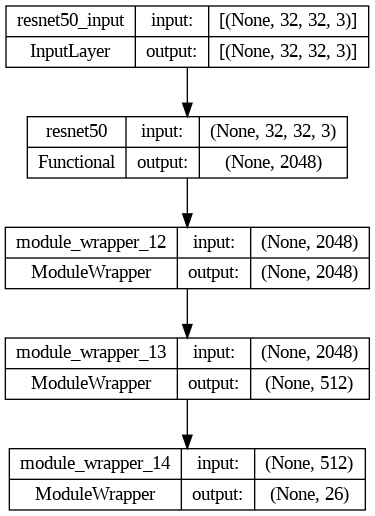

In [74]:
tf.keras.utils.plot_model(resnet_model, to_file='model.png', show_shapes=True, show_layer_names=True)

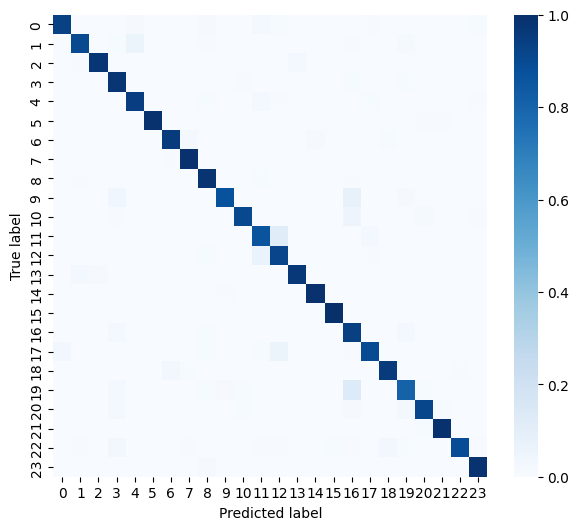

In [75]:

import seaborn as sns
import matplotlib.pyplot as plt

# Get the true labels by iterating over the validation generator
val_labels = []
for i in range(len(val_generator)):
    _, labels = val_generator[i]
    val_labels.extend(np.argmax(labels, axis=1))

# Get the predicted labels using the trained model
Y_pred = resnet_model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

# Compute the confusion matrix
cf_mat = confusion_matrix(val_labels, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]

# Plot the confusion matrix
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


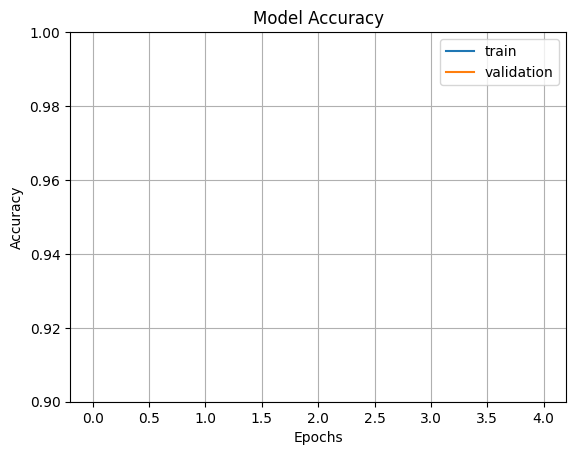

In [57]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.9,ymax=1)
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

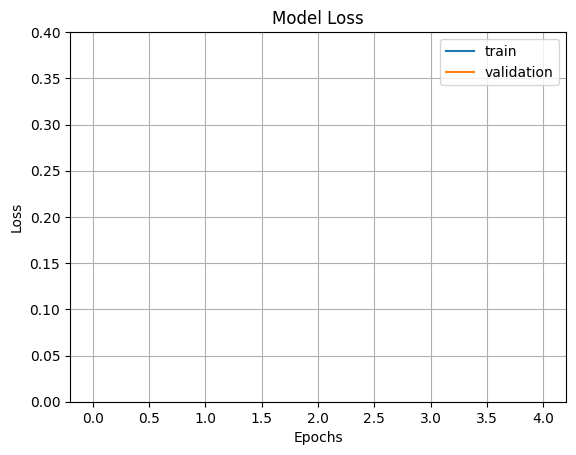

In [58]:
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axis(ymin=0,ymax=0.4)
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

### Predict Images 

In [59]:
#Creating a dictionary to map each of the indexes to the corresponding number or letter
from keras.preprocessing import image
dict = {0:"A",1:"B",2:"C",3:"D",4:"E",5:"F",6:"G",7:"H",8:"I",9:"J",10:"K",
        11:"L",12:"M",13:"N",14:"O",15:"P",16:"Q",17:"R",18:"S",19:"T",20:"U",21:"V",22:"W",23:"X",
        24:"Y",25:"Z"}


#Predicting images

img = image.load_img("sign_B2.jpg", target_size=(180, 180))
x = image.img_to_array(img)
plt.imshow(img)
x = np.expand_dims(x, axis=0)

image = np.vstack([x])
classes = resnet_model.predict(image, batch_size=64)
label = [np.argmax(i) for i in classes]
pred_class=[dict[x] for x in label]
pred_class

AttributeError: ignored

### Evaluating the Model 

_Plotting the Confusion Matrix_


In [60]:
Y_pred = resnet_model.predict_generator(val_generator)
y_pred = np.argmax(Y_pred, axis=1)

In [61]:
cf_mat = confusion_matrix(val_generator.classes, y_pred)
cf_mat_normalized = cf_mat.astype('float') / cf_mat.sum(axis=1)[:, np.newaxis]
plt.figure(figsize=(7, 6))
sns.heatmap(cf_mat_normalized, cmap="Blues")
plt.ylabel('True label')
plt.xlabel('Predicted label')

AttributeError: ignored

_Printing the Classification Report_

In [76]:
labels = val_generator.classes

AttributeError: ignored

In [79]:
print(classification_report(val_labels, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       237
           1       0.96      0.90      0.93       207
           2       0.99      0.97      0.98       239
           3       0.87      0.98      0.92       243
           4       0.92      0.94      0.93       193
           5       1.00      0.99      1.00       236
           6       0.96      0.96      0.96       229
           7       0.96      1.00      0.98       205
           8       0.93      0.98      0.95       226
          10       0.98      0.87      0.92       213
          11       0.98      0.91      0.94       257
          12       0.86      0.86      0.86       209
          13       0.83      0.92      0.87       220
          14       0.98      0.97      0.97       229
          15       0.99      1.00      0.99       214
          16       0.99      1.00      1.00       256
          17       0.78      0.94      0.85       257
          18       0.96    

_Evalutation Metrics on Test Set_

In [ ]:
loss, accuracy, f1_score, precision, recall = resnet_model.evaluate(val_ds, verbose=0)

In [ ]:
print(f"Test Loss: ", round(loss*100, 3), '%')
print(f"Test Accuracy: ", round(accuracy*100, 3), '%')
print(f"Test Precision: ", round(precision*100, 3), '%')
print(f"Test Recall: ",round(recall*100, 3), '%')
print(f"Test F1 Score: ",round(f1_score*100, 3), '%')

Test Loss:  4.699 %
Test Accuracy:  99.269 %
Test Precision:  99.411 %
Test Recall:  99.275 %
Test F1 Score:  99.342 %
